In [1]:
import sys
sys.path.append('../')

import tree_lib.bit_stream as bs
from tree_lib import tree
from tree_lib.encodings import two_choices
import random
import numpy as np
import matplotlib.pyplot as plt

# The effect of auto-correlation on tree size

I intuitively know that high auto-correlation leads to degerate trees, while a healthy alternation of zeros and ones leads to smaller trees. Let's see how much.

In [2]:
# Auto-correlation with lag 1
def gen_signal(length, auto_correlation):
    assert 0 <= auto_correlation <= 1
    assert length > 0
    first_bit = f"{random.randint(0, 1)}"
    signal = np.repeat("0", length)
    signal[0] = first_bit
    for i in range(1,length):
        signal[i] = signal[i-1] if random.random() < auto_correlation else f"{1-int(signal[i-1])}"

    return signal

def auto_correlation(signal):
    return 1-(np.sum(np.abs(np.diff(signal))) / (len(signal)-1))

In [3]:
# Testing ord
t = tree.TreeNode([tree.TreeNode(), 
                   tree.TreeNode([tree.TreeNode(),
                                  tree.TreeNode([
                                      tree.TreeNode(),
                                      tree.TreeNode()
                                  ]),
                                  tree.TreeNode()])])
print(t)
two_choices.tree_ord(t)
print(t)


[[], [[], [[], []], []]]
[[], [[[], [[[], []]], [[[]]]]]]


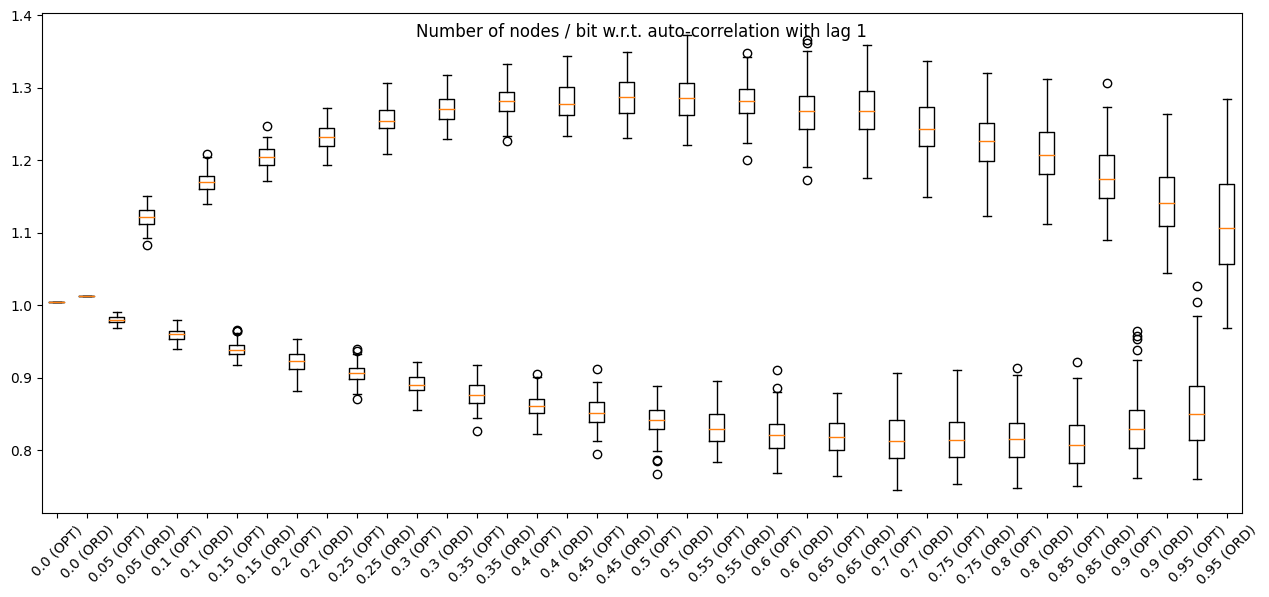

In [4]:
# Compute number of nodes in a tree that represents a random signal
# that has the given autocorrelation, divided by the signal length
# Effectively returns nodes/bits
def data_point(length, auto_correlation, encoding_function):
    stream = bs.bit_stream_literal(gen_signal(length, auto_correlation))
    t = encoding_function(stream)
    return t.n_descendants/length

SIG_LENGTH = 1000
NUM_EXAMPLES_PER_BOX = 100
NUM_AUTOCORRELATION_STEPS = 20

data_opt = [ [data_point(SIG_LENGTH, a, two_choices.bits_to_tree) 
             for _ in range(NUM_EXAMPLES_PER_BOX)] 
             for a in np.linspace(0., 1., NUM_AUTOCORRELATION_STEPS, False)]
data_ord = [ [data_point(SIG_LENGTH, a, two_choices.bits_to_tree_ord) 
              for _ in range(NUM_EXAMPLES_PER_BOX)] 
              for a in np.linspace(0., 1., NUM_AUTOCORRELATION_STEPS, False)]

# Zip and flatten
data = [dp for dpt in zip(data_opt, data_ord) for dp in dpt]

fig = plt.figure(figsize =(12, 5))
fig.suptitle("Number of nodes / bit w.r.t. auto-correlation with lag 1")
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)

labels = np.round(np.linspace(0., 1., NUM_AUTOCORRELATION_STEPS, False), 2).repeat(2)
labels = [str(labels[i]) + (" (OPT)" if i%2==0 else " (ORD)") for i in range(len(labels))]
ax.set_xticklabels(labels)
plt.xticks(rotation = 45)
plt.show()

# Zeros and Ones

A one always corresponds to the creation of at least one node. Therefore, the presence of many ones is despicable.

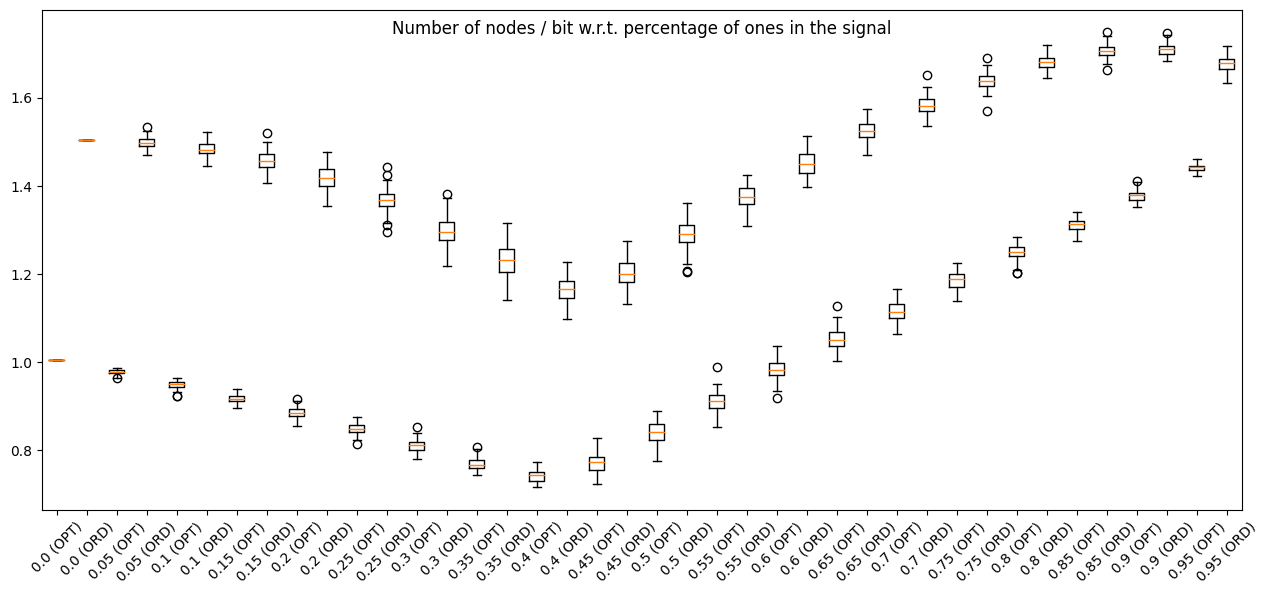

In [5]:
# Compute number of nodes in a tree that represents a random signal
# that has the given percentage of ones inside
def data_point(length, ones_perc, encoding_function):
    signal = np.random.choice(["0","1"], length, p=[1-ones_perc, ones_perc])
    stream = bs.bit_stream_literal(signal)
    t = encoding_function(stream)
    return t.n_descendants/length

SIG_LENGTH = 1000
NUM_EXAMPLES_PER_BOX = 100
NUM_STEPS = 20

data_opt = [ [data_point(SIG_LENGTH, p, two_choices.bits_to_tree) 
              for _ in range(NUM_EXAMPLES_PER_BOX)] 
              for p in np.linspace(0., 1., NUM_STEPS, False)]
data_ord = [ [data_point(SIG_LENGTH, p, two_choices.bits_to_tree_ord) 
              for _ in range(NUM_EXAMPLES_PER_BOX)] 
              for p in np.linspace(0., 1., NUM_STEPS, False)]

data = [dp for dpt in zip(data_opt, data_ord) for dp in dpt]

fig = plt.figure(figsize =(12, 5))
fig.suptitle("Number of nodes / bit w.r.t. percentage of ones in the signal")
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)

labels = np.round(np.linspace(0., 1., NUM_STEPS, False), 2).repeat(2)
labels = [str(labels[i]) + (" (OPT)" if i%2==0 else " (ORD)") for i in range(len(labels))]
ax.set_xticklabels(labels)
plt.xticks(rotation = 45)
plt.show()

# Leaves vs internal nodes

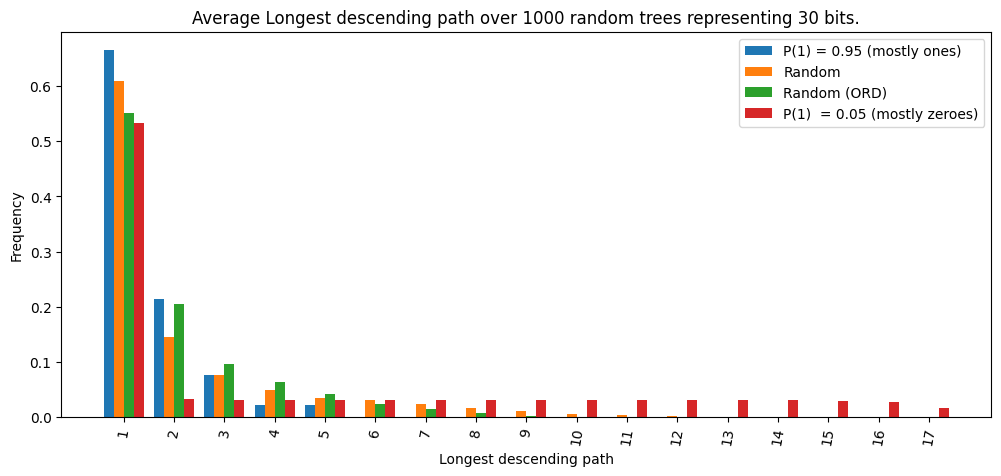

In [6]:
# Get stats of how many nodes there are with a certain 
# longest descending path
def per_longest_descending_path(t):
    per_ldp = np.zeros(t.longest_descending_path+1, dtype=float)
    for node in tree.iterate_tree_depth_first(t):
        per_ldp[node.longest_descending_path] +=1
    return per_ldp

# Compute percentage of nodes grouped by longest descending path
def data_point(length, ones_perc, encoding_function):
    signal = np.random.choice(["0","1"], length, p=[1-ones_perc, ones_perc])
    stream = bs.bit_stream_literal(signal)
    t = encoding_function(stream)
    per_ldp = per_longest_descending_path(t)
    return per_ldp / t.n_descendants

# Compute avg percentage of nodes grouped by longest descending path
def data_set(sig_length, num_examples, ones_perc, encoding_function):
    data = np.array([])
    for _ in range(num_examples):
        dp = data_point(sig_length, ones_perc, encoding_function)
        
        # Sum element-wise, extend dataset if needed
        longest = max(len(data), len(dp))
        data.resize(longest)
        dp.resize(longest)
        data += dp
    data /= num_examples # avg
    return np.delete(data, 0)

SIG_LENGTH = 30
NUM_EXAMPLES = 1000
ONE_PROB_IN_ZEROES_TEST=.05
ONE_PROB_IN_ONES_TEST=.95

data_random = data_set(SIG_LENGTH, NUM_EXAMPLES, .5, two_choices.bits_to_tree)
data_zeroes = data_set(SIG_LENGTH, NUM_EXAMPLES, ONE_PROB_IN_ZEROES_TEST, two_choices.bits_to_tree)
data_ones = data_set(SIG_LENGTH, NUM_EXAMPLES, ONE_PROB_IN_ONES_TEST, two_choices.bits_to_tree)
data_random_ord = data_set(SIG_LENGTH, NUM_EXAMPLES, ONE_PROB_IN_ONES_TEST, two_choices.bits_to_tree_ord)

longest = max(len(data_random), len(data_zeroes), len(data_ones), len(data_random_ord))
data_random.resize(longest)
data_zeroes.resize(longest)
data_ones.resize(longest)
data_random_ord.resize(longest)

X_axis = np.arange(1,len(data_random)+1)
fig = plt.figure(figsize =(12, 5))
plt.bar(X_axis-0.3, data_ones, 0.2, label = f"P(1) = {ONE_PROB_IN_ONES_TEST} (mostly ones)")
plt.bar(X_axis-0.1, data_random, 0.2, label = "Random")
plt.bar(X_axis+0.1, data_random_ord, 0.2, label = "Random (ORD)")
plt.bar(X_axis+0.3, data_zeroes, 0.2, label = f"P(1)  = {ONE_PROB_IN_ZEROES_TEST} (mostly zeroes)")

plt.xticks(X_axis, rotation=80)

# Customize the plot
plt.xlabel('Longest descending path')
plt.ylabel('Frequency')
plt.title(f"Average Longest descending path over {NUM_EXAMPLES} random trees representing {SIG_LENGTH} bits.")

# Display the plot
plt.legend()
plt.show()